## Descrição do projeto

Você recebeu uma tarefa analítica de uma loja online internacional. Seu predecessor não conseguiu completá-la: ele lançou um teste A/B e depois desistiu (para começar uma fazenda de melancias no Tocantins). Ele deixou apenas as especificações técnicas e resultado dos testes.

**Descrição Técnica**
- Nome do teste: recommender_system_test
- Grupos: A (controle) e B (funil de novos pagamentos)
- Data de início: 07-12-2020
- Quando paparam de receber novos usuários: 21-12-2020
- Data de término: 01-01-2021
- Público: 15% de novos usuários da região da UE
- Propósito do teste: testar mudanças relacionadas à introdução de um sistema de recomendação melhorado
- Resultado esperado: em até 14 dias após o cadastro, usuários mostram uma conversão melhor nas visualizações de página do produto (o evento product_page event), em adicionar itens ao carrinho (product_cart) e de compras (purchase). Em cada etapa do funil product_page → product_cart → purchase, haverá ao menos 10% de aumento.
- Número esperado de participantes do teste: 6000

## Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

## Carregando os arquivos

In [2]:
# o calendário de eventos de marketing para 2020
df_ab_calendario = pd.read_csv("ab_project_marketing_events_us.csv")

In [3]:
# todos os usuários que se cadastraram na loja online de 7 a 21 de dezembro de 2020
df_ab_users = pd.read_csv("final_ab_new_users_upd_us.csv")

In [4]:
# todos os eventos dos novos usuários dentro do período de 7 de dezembro de 2020 até 1 de janeiro de 2021
df_ab_events = pd.read_csv("final_ab_events_upd_us.csv")

In [5]:
#  tabela contendo os participantes do teste
df_ab_test = pd.read_csv("final_ab_participants_upd_us.csv")

## Visualizando os dados

In [6]:
df_ab_calendario.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [7]:
df_ab_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
df_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [9]:
df_ab_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


## Pré-Processamento dos dados

In [10]:
# Visualizando os dados e os tipos de dados
df_ab_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


## Observações sobre os dados df_ab_calendario

- Os dados do dataframe df_ab_calendario precisa de alterações de 'object' para 'datetime' nas seguintes colunas 'start_dt' e 'finish_dt'

In [11]:
# Procurando por valores duplicados
df_ab_calendario.duplicated().sum()

0

In [12]:
# Localizando valores ausentes
df_ab_calendario.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [13]:
# Convertendo o tipo de dado de 'start_dt'
df_ab_calendario['start_dt'] = pd.to_datetime(df_ab_calendario['start_dt'])

In [14]:
# Convertendo o tipo de dado de 'finish_dt'
df_ab_calendario['finish_dt'] = pd.to_datetime(df_ab_calendario['finish_dt'])

In [15]:
# Visualizando os dados
df_ab_calendario.head(14)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [16]:
# Visualizando os dados e os tipos de dados
df_ab_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


## Observação sobre os dados de df_ab_users

- Os dados do dataframe df_ab_users precisa de alterações de 'object' para 'datetime' na seguinte coluna 'first_date'.

- Também farei alterações no nome da coluna N.America para melhor entendimento sobre a região.

In [17]:
# Procurando por valores duplicados
df_ab_users.duplicated().sum()

0

In [18]:
# Localizando valores ausentes
df_ab_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [19]:
# Convertendo o tipo de dado de 'first_date'
df_ab_users['first_date'] = pd.to_datetime(df_ab_users['first_date'])

In [20]:
# ALterando o nome da string de 'N.America' > 'NA'
df_ab_users['region'] = df_ab_users['region'].replace('N.America', 'NA')

In [21]:
# Visualizando os dados
df_ab_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,NA,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,NA,iPhone


In [22]:
# Visualizando os dados e os tipos de dados
df_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [23]:
# Procurando por valores duplicados
df_ab_events.duplicated().sum()

0

In [24]:
# Localizando valores ausentes
df_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

# Observações sobre os dados de df_ab_events

- Os valores ausentes em df_ab_events[ details ] não tem relação com os valores que gastos(USD) ou seja não são números, não irei  dropar os valores pois não interferem em meu objetivo.

In [25]:
# Convertendo o tipo de dado de 'event_dt'
df_ab_events['event_dt'] = pd.to_datetime(df_ab_events['event_dt'])

In [26]:
# Visualizando os dados
df_ab_events.tail(10)

,user_id,event_dt,event_name,details
423751,1455450835F72F5E,2020-12-30 09:27:10,login,NaN
423752,339C4C55021A83C6,2020-12-30 12:55:08,login,NaN
423753,33E7BCF696B41C7B,2020-12-30 12:21:24,login,NaN
423754,D1553B56FFA8974B,2020-12-30 03:15:35,login,NaN
423755,6181F3835EBE66BF,2020-12-30 12:00:00,login,NaN
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


# Observações sobre os dados de df_ab_test

- Em df_ab_test não foi localizado valores faltantes ou duplicados, além de que os tipos de dados estão corretos para a análise.

In [27]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [28]:
df_ab_test.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [29]:
df_ab_test.duplicated().sum()

0

In [30]:
df_ab_test.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


## Análise exploratoria de dados (EDA)

Realize a análise exploratória de dados:
- Estude a conversão em diferentes etapas do funil.
- O número de eventos por usuário é distribuído igualmente entre as amostras?
- Os usuários de ambas as amostras estão presentes?
- Como o número de eventos é distribuído entre os dias?
- Existem quaisquer particularidades nos dados que você deve considerar antes de começar o teste A/B?

# Estude a conversão em diferentes etapas do funil

In [32]:
# Verificando os tipos de eventos únicos presente no dataframe
events_unique = df_ab_events['event_name'].unique()
#Visualizando os tipos de eventos
print(events_unique)

['purchase' 'product_cart' 'product_page' 'login']


In [33]:
df_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [34]:
df_ab_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [35]:
# Contando o número de usuários únicos em cada etapa do funil
users_product_page = df_ab_events[df_ab_events['event_name'] == 'product_page']['user_id'].nunique()
users_product_cart = df_ab_events[df_ab_events['event_name'] == 'product_cart']['user_id'].nunique()
users_purchase = df_ab_events[df_ab_events['event_name'] == 'purchase']['user_id'].nunique()
# Exibindo os usuários por etapa
print(f"Usuários na etapa 'product_page': {users_product_page}")
print(f"Usuários na etapa 'product_cart': {users_product_cart}")
print(f"Usuários na etapa 'purchase': {users_purchase}")

Usuários na etapa 'product_page': 38929
Usuários na etapa 'product_cart': 19284
Usuários na etapa 'purchase': 19568


In [36]:
# Filtrando os eventos do funil
df_page = df_ab_events[df_ab_events['event_name'] == 'product_page']
df_cart = df_ab_events[df_ab_events['event_name'] == 'product_cart']
df_purchases = df_ab_events[df_ab_events['event_name'] == 'purchase']

# Juntando com os grupos de teste [df_ab_test] para identificar quem é do grupo A e B
df_page = df_page.merge(df_ab_test, on='user_id', how='left')
df_cart = df_cart.merge(df_ab_test, on='user_id', how='left')
df_purchases = df_purchases.merge(df_ab_test, on='user_id', how='left')

# Contando os usuários únicos em cada etapa do funil por grupo [A,B]
users_page = df_page.groupby('group')['user_id'].nunique()
users_cart = df_cart.groupby('group')['user_id'].nunique()
users_purchase = df_purchases.groupby('group')['user_id'].nunique()

# Calculando as taxas de conversão
conversion_page_to_cart = (users_cart / users_page) * 100
conversion_cart_to_purchase = (users_purchase / users_cart) * 100

# Exibir os resultados
print("Conversão de 'product_page' para 'product_cart':")
print(conversion_page_to_cart)
print("\nConversão de 'product_cart' para 'purchase':")
print(conversion_cart_to_purchase)

Conversão de 'product_page' para 'product_cart':
group
A    47.676651
B    51.103864
Name: user_id, dtype: float64

Conversão de 'product_cart' para 'purchase':
group
A    108.014499
B     98.576338
Name: user_id, dtype: float64


In [37]:
# Taxas de conversão por grupo em %
conv_rate_page_to_cart_A = users_cart['A'] / users_page['A']
conv_rate_page_to_cart_B = users_cart['B'] / users_page['B']

conv_rate_cart_to_purchase_A = users_purchase['A'] / users_cart['A']
conv_rate_cart_to_purchase_B = users_purchase['B'] / users_cart['B']

print(f"Taxa de conversão de 'product_page' para 'product_cart' - Grupo A: {conv_rate_page_to_cart_A:.2%}")
print(f"Taxa de conversão de 'product_page' para 'product_cart' - Grupo B: {conv_rate_page_to_cart_B:.2%}")
print(f"Taxa de conversão de 'product_cart' para 'purchase' - Grupo A: {conv_rate_cart_to_purchase_A:.2%}")
print(f"Taxa de conversão de 'product_cart' para 'purchase' - Grupo B: {conv_rate_cart_to_purchase_B:.2%}")


Taxa de conversão de 'product_page' para 'product_cart' - Grupo A: 47.68%
Taxa de conversão de 'product_page' para 'product_cart' - Grupo B: 51.10%
Taxa de conversão de 'product_cart' para 'purchase' - Grupo A: 108.01%
Taxa de conversão de 'product_cart' para 'purchase' - Grupo B: 98.58%


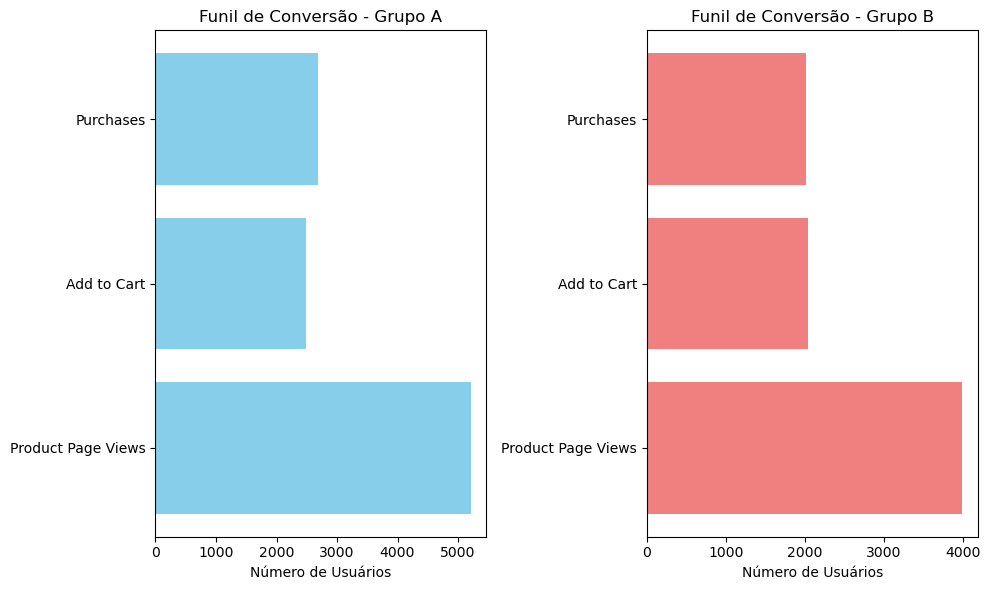

In [38]:
labels = ['Product Page Views', 'Add to Cart', 'Purchases']
group_a = [users_page['A'], users_cart['A'], users_purchase['A']]
group_b = [users_page['B'], users_cart['B'], users_purchase['B']]

# Config. tamanho do gráfico
plt.figure(figsize = (10, 6))

# Gráfico para o grupo A
plt.subplot(1, 2, 1)
plt.barh(labels, group_a, color='skyblue')
plt.title("Funil de Conversão - Grupo A")
plt.xlabel('Número de Usuários')

# Gráfico para o grupo B
plt.subplot(1, 2, 2)
plt.barh(labels, group_b, color='lightcoral')
plt.title("Funil de Conversão - Grupo B")
plt.xlabel('Número de Usuários')

# Plotando gráfico
plt.tight_layout()
plt.show()


Obs:

-  A partir da análise do gráfico, observamos que no grupo A (controle), houve um número maior de visualizações de produtos na página em comparação ao grupo B (funil de novos pagamentos). No entanto, no grupo B, foi possível notar uma melhoria nas etapas seguintes do funil, com um aumento no número de usuários que adicionaram produtos ao carrinho e completaram a compra.

# O número de eventos por usuário é distribuído igualmente entre as amostras?

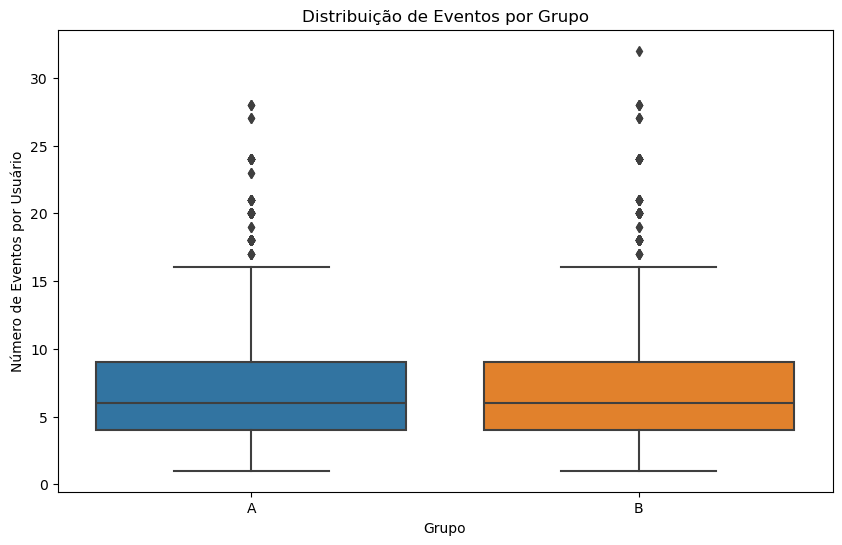

In [39]:
# O número de eventos por usuário é distribuído igualmente entre as amostras?

# Verificando o número de eventos por usuário
event_count_per_user = df_ab_events.groupby('user_id')['event_name'].count().reset_index(name='event_count')

# Adicionar o grupo (A ou B) ao dataframe de eventos
event_count_per_user = event_count_per_user.merge(df_ab_test[['user_id', 'group']], on='user_id', how='left')

plt.figure(figsize = (10, 6))
sns.boxplot(data = event_count_per_user, x='group', y='event_count')
plt.title('Distribuição de Eventos por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de Eventos por Usuário')
plt.show()


Obs:

- A maioria dos usuários realiza um número semelhante de eventos em ambos os grupos, como indicado pela proximidade das medianas. No entanto, o grupo B apresenta uma quantidade maior de outliers em comparação ao grupo A, sugerindo que, embora o comportamento típico dos usuários sejam semelhantes entre os grupos, há um número maior de usuários no grupo B que demonstram um nível de engajamento mais alto.

# Os usuários de ambas as amostras estão presentes?

In [40]:
# Verificando se todos os usuários de df_ab_test estão presentes em df_ab_events
usuarios_no_teste = set(df_ab_test['user_id'])
usuarios_nos_eventos = set(df_ab_events['user_id'])

# Comparar os usuários presentes em ambos
usuarios_faltantes = usuarios_no_teste - usuarios_nos_eventos
print(f'Usuários no teste e sem eventos: {len(usuarios_faltantes)}')

Usuários no teste e sem eventos: 0


Obs: 

- Os usuários de ambas as amostras estão presentes, não foi localizado nenhum usuário ausente nos testes.

# Como o número de eventos é distribuído entre os dias?

k:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
k:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


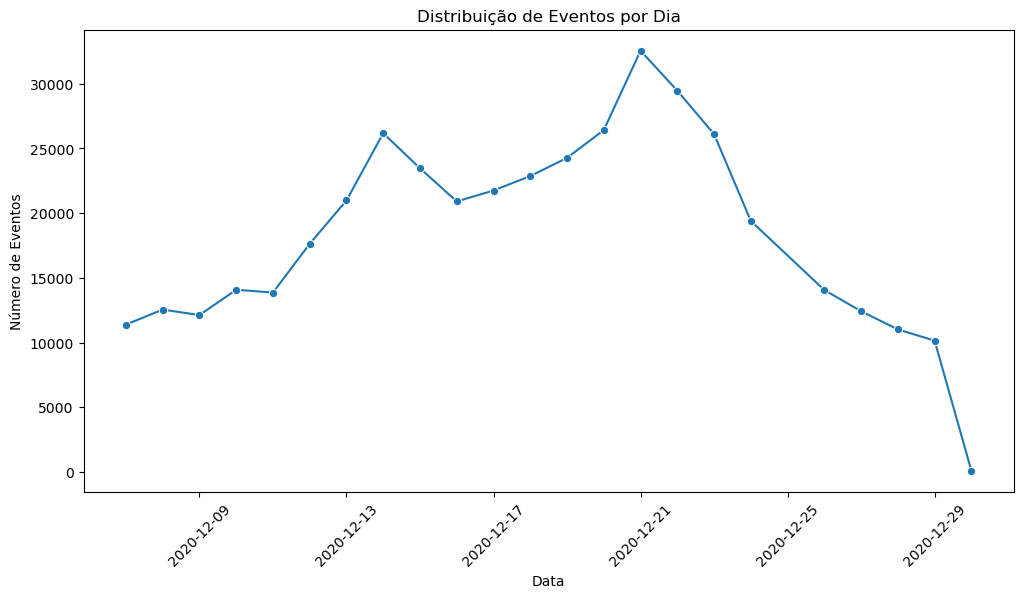

In [41]:
# Convertendo event_dt para formato datetime
df_ab_events['event_dt'] = pd.to_datetime(df_ab_events['event_dt'])

# Criando uma coluna de data para df_ab_events
df_ab_events['event_date'] = df_ab_events['event_dt'].dt.date

# Contando os eventos por dia
eventos_por_dia = df_ab_events.groupby('event_date').size().reset_index(name='event_count')

# Plotando a distribuição de eventos ao longo dos dias
plt.figure(figsize=(12, 6))
sns.lineplot(data=eventos_por_dia, x='event_date', y='event_count', marker='o')
plt.title('Distribuição de Eventos por Dia')
plt.xlabel('Data')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.show()

Obs:

- Podemos observar um aumento significativo no número de acessos nos dias 13/12/2020 e 21/12/2020, o que nos mostra picos de atividade durante esse período, possivelmente devido a promoções ou eventos sazonais entretanto, após o dia 23/12/2020, há uma queda notável nos acessos, sugerindo que a demanda ou o interesse diminuiu após esse pico.

- Possivelmente devido ao término das promoções ou à proximidade do período festivo quando os usuários tendem a acessar menos.

# Existem quaisquer particularidades nos dados que você deve considerar antes de começar o teste A/B?

In [42]:
# Identificando usuários com número de eventos muito alto ou baixo
usuarios_eventos = df_ab_events.groupby('user_id').size().reset_index(name='event_count')

# Detectando outliers (definir um limiar de eventos muito altos, por exemplo, acima de 95 % de percentil)
q95 = usuarios_eventos['event_count'].quantile(0.95)
outliers = usuarios_eventos[usuarios_eventos['event_count'] > q95]
print(f'Usuários com número de eventos acima de {q95}: {len(outliers)}')

# Listar alguns outliers
print(outliers.head())


Usuários com número de eventos acima de 15.0: 2469
             user_id  event_count
1   000199F1887AE5E6           16
8   000921BDA987CB74           17
25  00187B30B10E5180           16
40  00299902F77C0C2C           16
84  00607344650B2FB0           21


Obs: 

- Podemos observar alguns outliers em alguns dos usuários.

# Avalie os resultados do teste A/B:
- O que você pode dizer sobre os resultados do teste A/B?
- Use um z-test para verificar a diferença estatística entre as proporções.
- Descreva suas conclusões sobre a etapa da EDA e do resultado do teste A/B.

Obs: 

- No teste A/B eu pude notar que na etapa(evento) visualização da página do produto para adicionar ao carrinho foi contra o esperado ja que no teste A tivemos uma quantidade maior de usuários em comparação com o grupo B, entretanto pude observar um maior engajamento aos usuários do grupo B comparado ao grupo A.

In [43]:
# Definindo as contagens de sucesso (usuários que avançaram) e o número total de usuários para cada grupo
success_a = [users_cart['A'], users_purchase['A']]  # Número de usuários que avançaram nas etapas no grupo A
success_b = [users_cart['B'], users_purchase['B']]  # Número de usuários que avançaram nas etapas no grupo B

# Total de usuários que visualizaram o produto em cada etapa do funil no grupo A e B
n_a = [users_page['A'], users_page['A']]  # Total de usuários na etapa de visualização de produto no grupo A
n_b = [users_page['B'], users_page['B']]  # Total de usuários na etapa de visualização de produto no grupo B

# Z-test para verificar a diferença entre os grupos nas etapas product_cart e purchase
for i in range(len(success_a)):
    # Contagem de sucessos e número de observações (usuários totais) para cada grupo
    count = [success_a[i], success_b[i]]  # Sucessos para grupo A e B na etapa i
    nobs = [n_a[i], n_b[i]]  # Total de usuários que chegaram à etapa i no grupo A e B
    
    # Realizando o z-teste para proporções
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # Exibindo os resultados
    print(f"Etapa {i + 1}: Z-stat = {z_stat:.4f}, P-value = {p_value:.4f}")
    
    # Verificando se o resultado é estatisticamente significativo
    if p_value < 0.05: # nível de significância
        print(f"Conclusão: Há uma diferença estatisticamente significativa na etapa {i + 1} (p < 0.05).")
        # Interpretação adicional para o negócio
        if z_stat > 0:
            print(f"No grupo B, houve um desempenho superior ao grupo A na etapa {i + 1}. Isso indica que o novo sistema de recomendação está aumentando as conversões nesta etapa.")
        else:
            print(f"No grupo A, houve um desempenho superior ao grupo B na etapa {i + 1}. Isso indica que o sistema de recomendação do grupo B não está funcionando como esperado nessa etapa.")
    else:
        print(f"Conclusão: Não há diferença estatisticamente significativa na etapa {i + 1} (p >= 0.05).")
        print(f"Isso sugere que o novo sistema de recomendação não teve um impacto mensurável na conversão para a etapa {i + 1}.")


Etapa 1: Z-stat = -3.2575, P-value = 0.0011
Conclusão: Há uma diferença estatisticamente significativa na etapa 1 (p < 0.05).
No grupo A, houve um desempenho superior ao grupo B na etapa 1. Isso indica que o sistema de recomendação do grupo B não está funcionando como esperado nessa etapa.
Etapa 2: Z-stat = 1.0659, P-value = 0.2865
Conclusão: Não há diferença estatisticamente significativa na etapa 2 (p >= 0.05).
Isso sugere que o novo sistema de recomendação não teve um impacto mensurável na conversão para a etapa 2.


## Conclusão:

Obs: Na EDA investigamos a conversão em diferentes etapas do funil para o teste A/B e observei que o número de eventos por usuário e a presença dos usuários estavam bem distribuídos entre os grupos A (controle) e B (teste), também notei que o número de eventos vária de acordo com o dia e isso pode influenciar as taxas de conversão.


O teste A/B mostrou que o novo sistema de recomendação fez um ótimo trabalho em fazer com que mais pessoas adicionassem itens ao carrinho, mas não conseguiu aumentar significativamente o número de compras, além disso, vimos que o grupo B teve mais interações, o que sugere que o novo sistema gerou mais interesse, mas isso não se converteu em mais vendas.

## Sugestão:

Minha sugestão é que talvez seja útil ajustar o sistema de recomendação para tentar melhorar as taxas de conversão final, ou então investigar outros fatores que possam estar afetando a decisão de compra dos usuários.